<a href="https://colab.research.google.com/github/GildasTaliah/MeanVarianceOptimz/blob/main/MeanVarianceOptimz.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

The Mean Variance optimization identifies efficient portfolios interms of their expected returns $\hat{\mu}$ and variances $\hat{\sigma}$. The framework presented here is grounded in Markowitz portfolio theory.  

Expected returns usually reflect anticipated average returns for assets or portfolio, usually estimated from historical data, bayesian analysis, (machine learning) prediction etc. Variance and covariances, which is considered a measure of risk, actually indicates return variability, with higher values often signifying greater risk. While variance has limitations as a risk measure, it's widely used in portfolio analysis a (proxy) measure of risk.

The expected returns, variances and covariances would be computed as follows:   




\begin{align*}
\mu &=  \hat{\mu}_{i} = \frac{1}{T} \sum_{t=1}^{T} R_{it} \quad \text{for } i = 1, 2, \ldots, N  \quad and \quad  t = 1, 2, \ldots, T \\
\Sigma &= \hat{\sigma}_{ij} = \frac{1}{T} \sum_{t=1}^{T} (R_{it} - \hat{\mu}_i)(R_{jt} - \hat{\mu}_j) \quad \text{for } i,j = 1, 2, \ldots, N
\end{align*}




where $R_{it}$ represents the return for asset $i$ at time $t$, $T$ the number of historical return observations of asset $i$, $N$ the number of assets,  $\hat{\sigma}_{ij}$ is the covariance between the $i$-th and $j$-th stock returns (in case $i$ = $j$ it becomes the variance of the $i$-th stock returns).  


# Problem Statement

The portfolio returns and variance would be computed as such:


\begin{align*}
\text{Portfolio return} = \mu_{p} = \sum_{i=1}^{N} w_i \mu_{i}   = w' \mu
\end{align*}


\begin{align*}
\text{Portfolio variance} = \sigma_{p} = \sqrt{w' \Sigma w}
\end{align*}



Where $w$ represents the weight vector. The objective of the Mean Variance framework is to minimize portfolio variance $\sigma_{p}$ subject to certain constraints.


The portfolio selection problem considered in this project is  formulated in the following way:




\begin{align*}
\underset{w}{\text{Min:}} \quad w' \Sigma w  \\
\text{s.t:} \quad \sum_{i=1}^{N} w_i = 1
\end{align*}


\begin{align*}
\quad \quad \quad 0 \leq w_i \leq 1
\\
w' \mu = R_{TargetReturn}
\end{align*}



The optimization problem aims at minimizing the portfolios return variance, subject to the **budget constraint**, weights sum to $unity$ (which  further indicates the portfolio is fully invested) and the **non-negativity constraints** indicates we do not allow for $short selling$, while the last constraint (**target return level**) ensures that the portfolio's expected return is equal to the specified target return.

  

We start by writing the function necessary to download the data. The python packages $datetime$ and $yfinance$ will be used for this purpose, while the $pandas$ and $numpy$ package used for data manipulation is also imported.  Afterwards, we proceed to define the functions required to carry out the optimization routine (for the selected pair of stocks) as described above.





Some constraints would be left out in case where they are not needed. For example, when constructing the minimum variance portfolio, only the objective function, the budget constraint and the absence of short selling constraint would be considerd. Similarly, when maximizing the Sharpe ratio, the budget constraint and the absence of short selling constraint would be considerd and the objective function switches from minimizing portfolio variance to maximizing portfolio Sharpe ratio (implemented as minimizing **-sharpeRatio**). In these two cases, the target return constraint is dropped. The portfolio Sharpe ratio is computed as:


\begin{align*}
\text{Portfolio Sharpe ratio} = \frac{\mu_{p} - rf}{\sigma_{p}}
\end{align*}

where *rf* is the risk free rate, we consider 2.5% in this project. Actually, the current Germany 3 months Gorvernment bond yields is 3.819%.


## Download data
We now proceed to import some packages and define a custom function necessary for downloading the closing prices of a pair of stocks in a list.



In [1]:
import datetime as dt
import yfinance as yf
import pandas as pd

St = dt.datetime(2019, 1, 1)
Sp = dt.datetime(2023, 12, 31)
def read_data(ticker_list, start = St, end = Sp):

  '''
  This function takes in a list of tickers - ticker_list, downloads historical
  prices from yahoo for the (default) timeframe - St, Sp.  Extracts the closing
  prices for each ticker and returns a dataframe with the merged data.
  '''

  DataFrame = pd.DataFrame()
  for tick in ticker_list:
    stock = yf.Ticker(tick)
    prices = stock.history(start=start, end=end)
    # Change  index to date-only
    prices.index = pd.to_datetime(prices.index)
    closing_prices = prices['Close']
    DataFrame[tick] = closing_prices

  return DataFrame

In [3]:

# 15 Randomly selected stocks from DAX Plus Export Strategy index composition
ExpTick = (["WAF.DE", "HEI.DE", "PUM.DE", "SY1.DE", "MRK.DE", "SHL.DE", "MOR.DE",
"KRN.DE", "G1A.DE", "MTX.DE", "HEN3.DE", "ADS.DE", "FRE.DE", "BAYN.DE","BOSS.DE"])

# 20 Randomly selected from DAX Plus Maximum Dividend index composition
DivTick = (["AIXA.DE", "ALV.DE", "BAS.DE", "BMW.DE", "BC8.DE", "BNR.DE", "CBK.DE",
"EVD.DE", "DBK.DE", "DB1.DE", "EOAN.DE", "FNTN.DE", "GXI.DE", "HEN3.DE", "NEM.DE",
"PUM.DE", "G24.DE", "O2D.DE", "VOW3.DE", "WCH.DE" ])

# 30 Randomly selected stocks from DAX 50 ESG index composition
EsgTick = ([ "FRA.DE", "DBK.DE",  "ADS.DE", "ALV.DE", "NDA.DE", "BAS.DE", "BMW.DE",
"BEI.DE", "CBK.DE",  "1COV.DE", "DB1.DE", "DTE.DE", "FNTN.DE",  "FRE.DE", "G1A.DE",
"HNR1.DE", "HEN3.DE", "BOSS.DE", "IFX.DE",  "LIN.DE", "LHA.DE", "MRK.DE", "MUV2.DE",
"SAP.DE", "G24.DE", "SIE.DE", "TLX.DE", "O2D.DE", "VNA.DE", "WCH.DE"])

Tickers = {'DaxExpTick': ExpTick, 'DaxDivTick': DivTick, 'DaxEsgTick': EsgTick}


## Compute Returns
All data underwent thorough checks to ensure completeness, and stocks with missing values were excluded from the analysis. For optimal weight determination, we utilized daily data from January 2019 to December 2023 for the in-sample period, while the out-of-sample evaluation spanned from January 2024 to March 2024 to assess performance. we now compute retuns which will be the input to the optimization process



In [6]:
# Download data and compute simple returns.
Returns = ({ key: read_data(ticker).pct_change().dropna() for key, ticker in
           Tickers.items()})

# Optimal Portfolio Weights

We define the function $MinVolMaxSharpe$ to take in return data and compute the optimal weights for the Minimum Volatility and Maximal Sharpe ratio portfolio.

Since our objective functions (portfolio variance and Sharpe ratio) are quadratic in nature and twice continuously differentiable, we use the Sequential Least Squares programming algorithm -  **SLSQP** optimizer, which is considered an optimization algorithm ideal for mathematical problems where the objective function is twice continuously differentiable. We utilize the $scipy$ package to carry out the entire optimization routine

In [7]:
import scipy.optimize as sco
import numpy as np

def MinVolMaxSharpe(ret):

  ''' Input: Takes in Stock Returns Matrix, computes the optimal weights for the
  given object functions: Min Vol and Max Sharpe.
  Output : return a weight matrix: Equally, Min Vol and Max Sharpe weights
  '''

  # Number of asset
  noa = len(ret.columns)

  # Initial weights: Equally weighted
  W = np.repeat(1/noa, noa)

  # Portfolio return, vol and sharpe ratio function
  def port_ret(W):
    return np.sum(ret.mean() * W) * 252


  def port_vol(W):
    return np.sqrt(np.dot(W.T,  np.dot(ret[ret < 0].cov() * 252, W)))

  def min_func_sharpe(W):
    return - (port_ret(W) - 0.025) /port_vol(W)

  # Budget and non-negativity contraints
  cons = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})
  bnds = tuple((0,1) for i in range(noa))

  # Minimizing the portfolio volatility: mv
  optmv = (sco.minimize(
          # objective function: OF
          port_vol,
          # Initial guess, which is the equal weight array: IW
          W,
          method = 'SLSQP', constraints= cons, bounds= bnds))
  mvW = optmv['x']
  mvret = port_ret(optmv['x'])
  mvvol = port_vol( optmv['x'])

  eqret = port_ret(W)
  eqvol = port_vol(W)
  print(f'EquallyWReturns: {eqret * 100} Vol: {eqvol * 100}')
  print(f'MinVolReturns: {mvret * 100} Vol: {mvvol * 100}')


  # Maximizing the portfolio sharpe ratio: ms
  optms = (sco.minimize(
          # OF          # IW
          min_func_sharpe, W, method = 'SLSQP', constraints= cons,
                     bounds= bnds))
  msW = optms['x']
  msret = port_ret( optms['x'])
  msvol = port_vol(optms['x'])
  print(f'MaxSharpeReturns: {msret * 100} Vol: {msvol * 100}')

  dataW = pd.DataFrame({'EqualW': W,  'MinVolW': mvW, 'MaxShapW': msW})

  return dataW

In [8]:
# Obtain Optimal weights
W = ({key:(print(key), MinVolMaxSharpe(ret))[1] for key, ret in Returns.items()})




DaxExpTick
EquallyWReturns: 9.369579688875993 Vol: 16.77208176163959
MinVolReturns: 6.903938833689459 Vol: 12.883662379188237
MaxSharpeReturns: 14.591652491066831 Vol: 15.23216938104633
DaxDivTick
EquallyWReturns: 16.816448017103312 Vol: 17.1703882793507
MinVolReturns: 10.462280858090855 Vol: 12.288968242403044
MaxSharpeReturns: 30.04107352306253 Vol: 19.80909726437358
DaxEsgTick
EquallyWReturns: 14.019388542480046 Vol: 17.53522751560522
MinVolReturns: 9.429502084449252 Vol: 11.963533408117154
MaxSharpeReturns: 22.024936332789718 Vol: 15.435875511757255






Above, we observe the results from the in-sample optimization process. The findings indicate that the *minimum volatility* portfolio constructed from the **DAX ESG** composition exhibits the *lowest volatility* at 11.96%. Conversely, the *maximum Sharpe* portfolio constructed from the **DAX Dividend** composition experiences the *highest volatility* at 19.81%, followed by the *equally weighted* portfolio under the **DAX ESG** with 17.54% volatility. The *minimum volatility* is unsurprisingly the least volatile investment strategy across all sectors on average.

The **DAX Dividend** however enjoys the *highest return* at 30.04%, followed by **DAX ESG** at 22.03% both constructted utilizing the *maximum Sharpe* investment strategy. Now, let us explore how these portfolios perform out-of-sample, which would be perhaps the most important outcome of this analysis.



# Out-of-sample results

In [9]:
#  Function to compute out-sample portfolio return with optimal weights
def port_return(R, W):

  ''' Input: R - Dataframe of Out-sample returns data.
  W - Matrix of optimal (equally, MinVol, MaxSharpe) weights '''

  # Create frame to store results
  port_df = pd.DataFrame()

  # Compute portfolio returns for each column
  for col in W.columns:
    p_ret = np.dot(R, W[col])
    port_df[col] = p_ret

  return port_df



As indicated earlier, the out-of-sample period corresponds to the first quarter of 2024. We will now proceed to download the data, compute returns, and calculate the out-of-sample portfolio returns.

In [10]:
St = dt.datetime(2024, 1, 1)
Sp = dt.datetime(2024, 3, 31)

O_Returns = ({ key: read_data(ticker, St, Sp).pct_change().dropna() for key, ticker
            in Tickers.items()})

In [13]:
# @title Out-sample results
# arithmetic mean of daily returns
O_portRet = {key: port_return(O_Returns[key], W[key]) for key in W.keys()}
mean = {key: (df.mean() * 100) for key, df in O_portRet.items()}
pd.DataFrame(mean).T

,EqualW,MinVolW,MaxShapW
DaxExpTick,0.122673,0.141641,0.164656
DaxDivTick,0.078082,0.096689,-0.196059
DaxEsgTick,0.071740,0.061067,0.191973


Maximum Sharpe portfolio strategy implemented using the **DAX ESG** composition achieved the highest average daily return at 0.19%, followed by the same investment strategy under the **DAX Export**  composition at 0.16%. However, the maximum Sharpe investment strategy performed poorly under the **DAX Dividend** composition at a low of -0.2% average daily returns.

In [14]:
# Daily standard deviation
std = {key: (df.std() * 100) for key, df in O_portRet.items()}
pd.DataFrame(std).T

,EqualW,MinVolW,MaxShapW
DaxExpTick,0.762302,0.776743,0.799777
DaxDivTick,0.638994,0.649333,1.846999
DaxEsgTick,0.562315,0.590452,0.711464




While the maximum Sharpe strategy experienced a negative average daily return of -0.2% when implemented with the **DAX Dividend** composition, it also exhibited the highest daily volatility among other investment strategies across the other sectors at 1.85%.

In [15]:
# Sharpe ratio
SR = {key: (df.mean() / df.std()) for key, df in O_portRet.items()}
pd.DataFrame(SR).T

,EqualW,MinVolW,MaxShapW
DaxExpTick,0.160925,0.182352,0.205877
DaxDivTick,0.122195,0.148905,-0.106150
DaxEsgTick,0.127580,0.103425,0.269828


 For the first quarter of 2024, the maximum Sharpe investment strategy implemented using the **DAX ESG** composition achieved the highest Sharpe ratio of 0.26.

In conclusion, all investment strategies performed well with the **DAX ESG** composition, indicating stability in the ESG sector. However, while the maximum Sharpe ratio was outstanding under the **DAX Export** sector, it performed poorly under the **DAX Dividend** sector, recording a negative Sharpe ratio of -0.11. **A key takeaway from our analysis is that a unique investment strategy performs well for a certain sector**.

<Axes: title={'center': '2024 Q1 Sharpe Ratio'}>

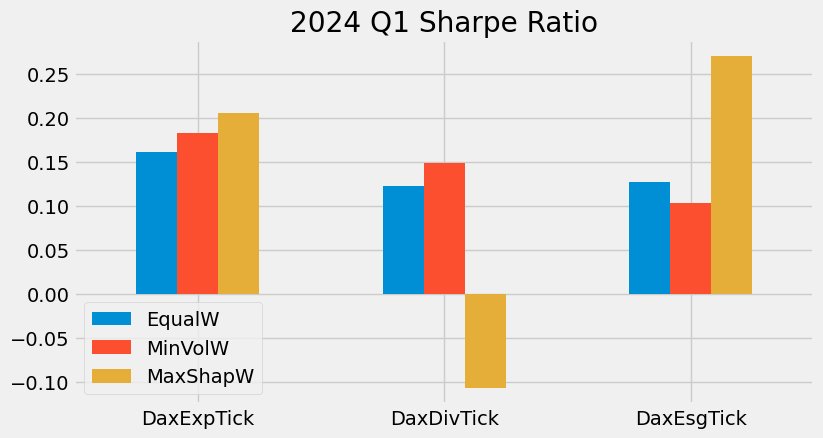

In [16]:
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

pd.DataFrame(SR).T.plot(kind='bar', figsize=(8.5, 4.5), rot=0,
                          title='2024 Q1 Sharpe Ratio')

Empirical studies (quantitative research) have shown that the input parameters are often full of noise, that is lots of estimation errors are present in the parameters expected returns and variance-covariances, which often results to the optimizers optimizing these errors and reulting to poor portfolio allocation.

In the future, we'll evaluate the impact of minimizing these estimation errors and assess their impact on how they perform out-of-sample. We plan to explore techniques such as Black-Litterman, shrinkage estimation, and even machine learning techniques to enhance the process of obtaining optimal portfolio weights that are optimal out-of-sample.

It's worth noting that this analysis excludes some important aspects typically considered during backtesting. Examples of such aspects include but not limited to: transaction costs, slippage, survivorship bias, and liquidity constraints.

As a result, the conclusions drawn from this analysis should not be entirely relied upon. We conclude this analysis by utilizing the DAX 40 index to produce an efficient frontier, and that will be it for now.

# The Efficient Frontier

The **Efficient  Frontier** (EF) is a set of all non-dominated portfolios - these portfolios dominate all other portfolios in terms of expected returns given a certain level of risk (variances-covariances).  Put if differently, the EF comprises of all portfolios which have maximum return $\mu_p$ for a given level of variance $\sigma_p$

In [17]:
# URL of the Wikipedia page containing the list of DAX companies
url = 'https://en.wikipedia.org/wiki/DAX'

# Read HTML table from the URL
dax_df = pd.read_html(url)[4]  #DAX 40 table is the fourth on the page

# Extract the tickers from the 'Ticker' column
dax_tickers = dax_df['Ticker'].tolist()

# Display the first few tickers
print(dax_tickers[:5])

['ADS.DE', 'AIR.DE', 'ALV.DE', 'BAS.DE', 'BAYN.DE']


In [18]:
# Downlaod historical price data for each ticker, and show first five firms
St = dt.datetime(2020, 3, 1)
Sp = dt.datetime(2024, 3, 31)
data = read_data(dax_tickers, St, Sp)
print(data.shape)
data.head().iloc[:, :5]

(1042, 40)


,ADS.DE,AIR.DE,ALV.DE,BAS.DE,BAYN.DE
Date,,,,,
2020-03-02 00:00:00+01:00,238.553207,104.484947,157.062317,41.146854,55.697758
2020-03-03 00:00:00+01:00,242.809631,108.858742,159.266006,41.511326,54.910866
2020-03-04 00:00:00+01:00,244.163925,107.770149,160.902588,42.015392,57.297180
2020-03-05 00:00:00+01:00,240.971619,104.523827,157.985931,41.348473,56.732681
2020-03-06 00:00:00+01:00,233.184311,96.835670,153.043793,40.844414,54.551640


In [80]:
#data.info()
#data.isna().sum()

In [19]:
# Drop column with NA
# data.isna().sum()
Newdata = data.drop(['DTG.DE', 'DHL.DE', 'P911.DE',  'ENR.DE', ], axis = 1)
Newdata.shape

(1042, 36)

In [20]:
# Compute Returns
ret = Newdata.pct_change().dropna() * 100
print(ret.shape)

(1041, 36)


In [21]:
# Number of asset
noa = len(ret.columns)

# Initial weight: Equal weight
w = np.repeat(1/noa, noa)


In [22]:
# Portfolio return and portfolio variance function
def port_ret(w):
  return np.sum(ret.mean() * w) * 252

def port_vol(w):
  return np.sqrt(np.dot(w.T,  np.dot(ret.cov() * 252, w)))


In [23]:
# @title Max Sharpe and Min Volatility portfolio: DAX 40
# Now DAX 36: hahahaha! (4 stocks dropped due to missing values)

def min_func_sharpe(w):
  return - (port_ret(w) - 0.025) /port_vol(w)

# Contraints and bounds
cons = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})
bnds = tuple((0,1) for i in range(noa))

# Maximizing the portfolio sharpe ratio
optms = (sco.minimize(
        # OF          # IW
        min_func_sharpe, w, method = 'SLSQP', constraints= cons, bounds= bnds))

msW = optms['x']
msret = port_ret(msW)
msvol = port_vol(msW)
print(f'MaxPort Returns {msret} Vol {msvol}')

# Minimizing the portfolio volatility
optmv = (sco.minimize(
        # OF   # IW
        port_vol, w, method = 'SLSQP', constraints= cons, bounds= bnds))
mvW = optmv['x']
mvret = port_ret(mvW)
mvvol = port_vol(mvW)
print(f'MinPort Returns {mvret} Vol {mvvol}')


MaxPort Returns 36.646441755970905 Vol 24.29401654271867
MinPort Returns 11.813423558882864 Vol 14.288146245183501


0    0.441465
dtype: float64


' Most stocks are allocated circa 0.0% of the  portfolio weights, whereas a \nwhooping 44.15% of the weights are alloted to one stock - suboptimal weighting!'

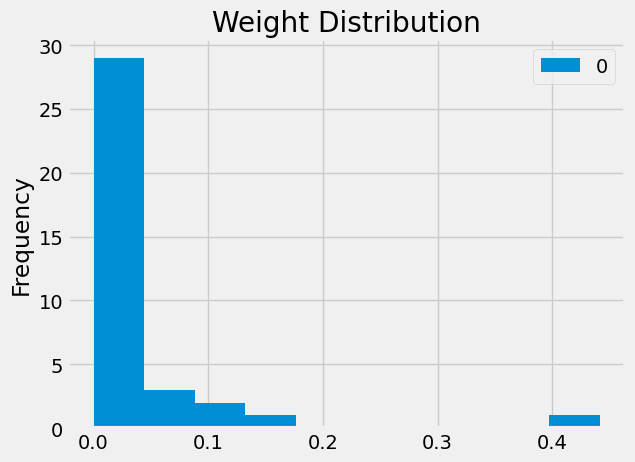

In [24]:
# @title Weight distribution: Maximum Sharpe portfolio
print(pd.DataFrame(msW).max())
pd.DataFrame(msW).plot(kind = 'hist', title = 'Weight Distribution' )
''' Most stocks are allocated circa 0.0% of the  portfolio weights, whereas a
whooping 44.15% of the weights are alloted to one stock - suboptimal weighting!'''

0    0.245748
dtype: float64


' Likewise most stocks are apportioned approximately 0.0% of total weights '

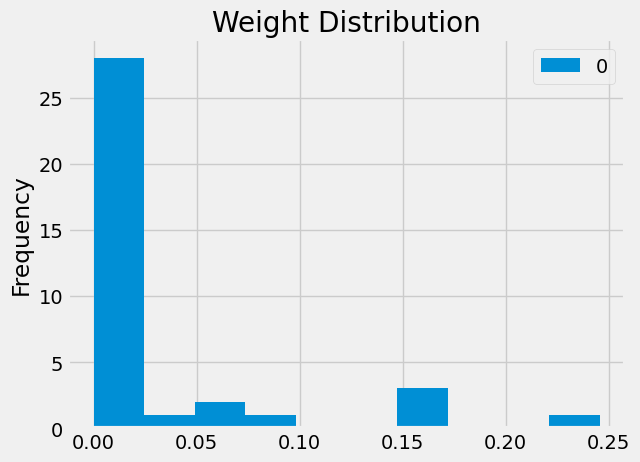

In [25]:
# @title Weight distribution: Minimum Volatility portfolio
print(pd.DataFrame(mvW).max())
pd.DataFrame(mvW).plot(kind = 'hist', title = 'Weight Distribution' )
''' Likewise most stocks are apportioned approximately 0.0% of total weights '''

In [26]:
# Contraints
cons = ({'type': 'eq', 'fun': lambda w: port_ret(w) - tret} ,{'type': 'eq',
       'fun': lambda w: np.sum(w) - 1})
bnds = tuple((0,1) for i in range(noa))

# Create a range of target expected returns and an empty list for volatilities
trets = np.linspace(mvret * 0.75, msret * 1.1, 100)
tvols = []

# Minimize volatility for target expected returns
for tret in trets:
  res = (sco.minimize(port_vol, w, method = 'SLSQP',
         constraints= cons, bounds= bnds))
  tvols.append(res['fun'])

tvols = np.array(tvols)


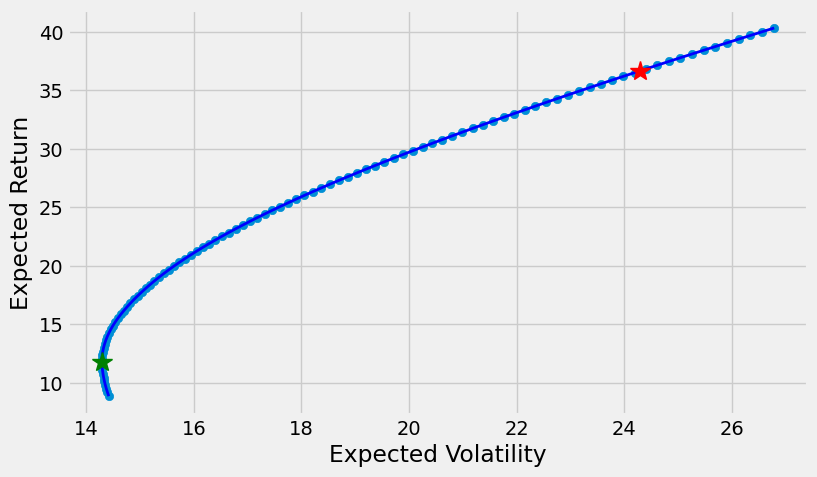

In [27]:
# @title Efficient Frontier

plt.figure(figsize=(8.5,5))
plt.scatter(tvols, trets)
plt.plot(tvols, trets, 'b', lw = 2)

plt.plot(mvvol, mvret, 'g*', markersize = 15)
plt.plot(msvol, msret, 'r*', markersize = 15)

plt.xlabel('Expected Volatility')
plt.ylabel('Expected Return')
plt.show()

# References

Markowitz, H. M. (1952). Portfolio Selection. The Journal of Finance, 7(1), 77-91.

Hilpisch, Y. (2019). Python for Finance, 2nd Edition. O’Reilly Media.